In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')  # 폰트 지정
plt.rc('axes', unicode_minus=False)  # 마이너스 폰트 설정
%config InlineBackend.figure_format = 'retina'  # 그래프 글씨 뚜렷

import os
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
df_train = pd.read_csv("../data/preprocessed/df_train001.csv")

---

In [5]:
df_train.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,0.0,68.3,1.7,6.7,11.933,48.699342,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,11.933,48.699342,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,11.933,48.699342,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,11.933,48.699342,7.5
4,1960-01-05,1.3,-8.2,9.5,0.0,44.0,5.1,8.2,11.933,48.699342,-4.6


In [6]:
df_train['일시'] = pd.to_datetime(df_train['일시'])
df_train.set_index('일시', inplace=True)

In [8]:
train_size = int(len(df_train) * 0.8)
y_train, y_test = df_train['평균기온'][:train_size], df_train['평균기온'][train_size:]

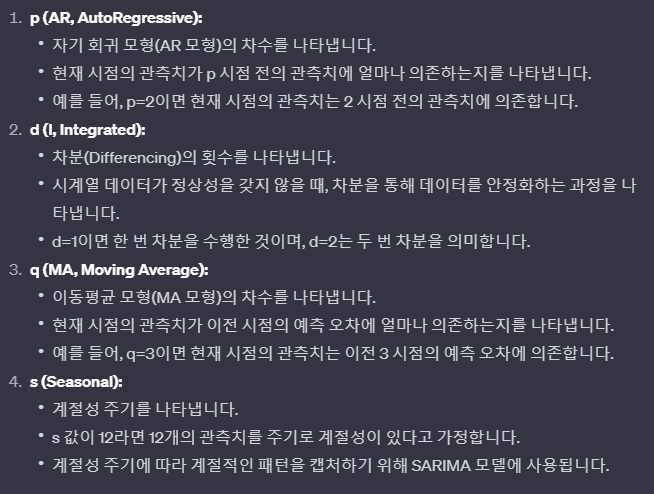

In [22]:
# 모델 생성 및 학습
model = SARIMAX(y_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)) # p,d,q,s
result = model.fit()

In [23]:
pred = result.get_prediction(start=y_test.index[0], end=y_test.index[-1], dynamic=False)
pred_ci = pred.conf_int()

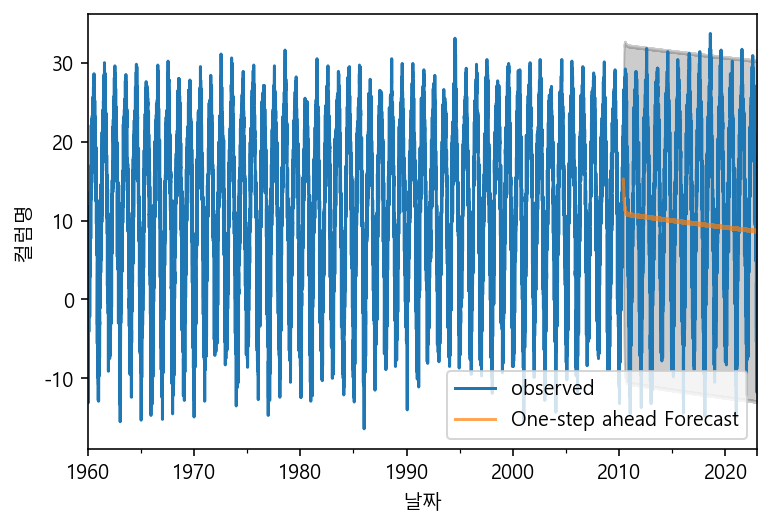

In [24]:
# 시각화
ax = df_train['평균기온'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
ax.set_xlabel('날짜')
ax.set_ylabel('컬럼명')
plt.legend()
plt.show()

---

In [29]:
sub_file = pd.read_csv("../data/original/sample_submission.csv")

In [36]:
target = pd.to_datetime(sub_file['일시'])

In [40]:
pred = result.get_prediction(start=target.values[0], end=target.values[-1], dynamic=False)

In [57]:
sub_file['평균기온'] = pred.predicted_mean.values

In [62]:
sub_file.to_csv("../data/sub/001_SARIMAX.csv", index=False, encoding='utf-8')

---

In [63]:
import joblib

In [64]:
joblib.dump(result, '../model/sarimax_model_001.pkl')

['../model/sarimax_model_001.pkl']

In [65]:
loaded_model = joblib.load('../model/sarimax_model_001.pkl')

In [70]:
# 예측 수행 (불러온 모델로 예측 가능)
forecast = loaded_model.get_forecast(steps=10)

forecast.conf_int()

,lower 평균기온,upper 평균기온
2010-05-26,10.665448,19.810015
2010-05-27,8.324217,22.214239
2010-05-28,6.535692,23.719274
2010-05-29,5.070407,24.846542
2010-05-30,3.666654,25.594000
2010-05-31,2.769377,26.534975
2010-06-01,1.898631,27.264856
2010-06-02,1.029434,27.807689
2010-06-03,0.216782,28.252682
2010-06-04,-0.386004,28.778270
